## Markov Chain Monte Carlo and the Metropolis-Hastings Algorithm
Sinnott Murphy
15688, Fall 2016


### 1. Motivation
This notebook will introduce readers to Markov chain Monte Carlo sampling and the Metropolis-Hastings algorithm. 

Monte Carlo methods are algorithms that use randomness to solve difficult problems in optimization and numerical integration. In machine learning and statistics, we will often want to compute probability distributions (or statistics that are based on probability distributions) that are difficult or impossible using analytic methods. However, such distributions and statistics could be readily approximately given enough representative samples from the distribution of interest. This is the objective of Markov chain Monte Carlo (MCMC) methods. 

These methods are often used in Bayesian statistics to determine the posterior distribution, which is a probability distribution over our parameters, theta $(\theta)$, given the observed data, X. Using Bayes rule, the equation for the posterior distribution is: $${P}(\theta|X) = \frac{{P}(X|\theta)*{P}(\theta)}{{P}(X)}$$ where ${P}(X|\theta)$ is the likelihood, ${P}(\theta)$ is the prior distribution (our beliefs about $\theta$ prior to seeing data), and ${P}(X)$ is the marginal likelihood of the data. The primary challenge is in computing the denominator of this expression. Barring simple cases (e.g. using "conjugate priors"), MCMC is often the only tractable solution.

### 2. Introduction to Markov chains
A Markov chain is a stochastic process--a time series--whose conditional probability distribution for its future state (in period $t+1$) depends only on its current state (in period $t$). In other words, the process exhibits "memorylessness" in that previous states ($t = 1, 2, \dots, t-1$) have no influence on future states, given knowledge of the current state:

$${P}(X_n=x_n|X_{n-1}=x_{n-1},X_{n-2}=x_{n-2}, \dots, X_0=x_0) = {P}(X_n=x_n|X_{n-1}=x_{n-1})$$

If the state space of the Markov chain is finite, its probabilities of transitioning between any two states can be represented by a transition matrix, $M$, where the $(i,j)^{th}$ element represents the probability of transitioning from state $i$ (in period $t$) to state $j$ (in period $t+1$). All values $m_{ij}$ $\in [0,1]$ and each row of $M$ must sum to 1. Note that any two states that are not directly connected will have a value of 0 in the corresponding element of $M$. In addition to a transition matrix, a Markov chain has a vector of initial values representing the probability distribution over the starting states.

Below is an example of a two-state Markov chain:

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://upload.wikimedia.org/wikipedia/commons/2/2b/Markovkate_01.svg", width=400)

And below is the corresponding transition matrix:

In [2]:
import pandas as pd
col1 = pd.Series([0.6, 0.7], index=['A', 'E'], name='A')
col2 = pd.Series([0.4, 0.3], index=['A', 'E'], name='E')
pd.concat([col1, col2], axis=1)

,A,E
A,0.6,0.4
E,0.7,0.3


Here are a few other important properties of Markov chains:
1. **Reducible** or **irreducible**: If the Markov chain's entire state space is a single communicating class (meaning if you can get to all states from any state, either directly or indirectly) the Markov chain is irreducible. Otherwise it is reducible. 
2. **Periodic** or **aperiodic**: If there are not a set number of time steps that must elapse between the Markov chain returning to a previous state from the current state, the Markov chain is aperiodic. Otherwise it is periodic. 
3. **Recurrent**: Given infinite time, if the Markov chain is guaranteed to return to each state, rather than getting trapped in self-contained loops, the Markov chain is recurrent. 

Markov chains that are irreducible, aperiodic, and recurrent are termed **ergodic**. Ergodic Markov chains are guaranteed to have a **unique stationary distribution** that will be converged to if the Markov chain is allowed to run long enough. After convergence, the proportion of time spent in each of the states will be representative of its stationary distribution, regardless of the starting point (i.e. initial $\theta$). Thus, if we can identify a Markov chain whose stationary distribution is the posterior distribution we wish to know, we can characterize that posterior distribution just by drawing a large number of samples from the corresponding Markov chain. Thus the goal of MCMC can be thought of as generating a Markov chain that will allow us to draw samples from the desired distribution.

### 3. An overview of Markov chain Monte Carlo sampling via Metropolis-Hastings
So how do we construct a Markov chain having a stationary distribution that matches our posterior distribution? The Metropolis-Hastings (MH) algorithm is one such approach. 

The components of the MH algorithm include a **proposal distribution** which proposes updates to $\theta$ (taken to be $N(0, \sigma)$ for simplicity, though other options exist); a **target distribution** defined as the numerator of the posterior distribution of interest, i.e. ${P}(X|\theta)*{P}(\theta)$; and an **acceptance criterion**. The proposal distribution is used to generate updates to $\theta$, while the acceptance criterion determines whether we should accept the proposed update, based on whether the update would move us toward higher probability density according to the target distribution. 

The algorithm proceeds as follows:
1. Initialize $\theta$ randomly
2. Draw a proposed update to $\theta$ from the Gaussian distribution
3. Determine whether the proposed update is accepted and update accordingly
4. Repeat steps 2 and 3 many times (e.g. 10,000)

At its core, the MH algorithm is a **random walk** over our parameter space: each update to $\theta$ is drawn completely at random from a Gaussian distribution centered at the existing value. Yet while proposed updates are random, not all updates have equal probability of being accepted. Step 3 of the algorithm determines whether a proposed update is accepted. There are two acceptance cases: the first is when the new value of $\theta$ increases the posterior probability of $\theta$ conditional on the data we've observed. Let $\rho$ equal the ratio of conditional probabilities of the target distribution under the proposed and current values of $\theta$, i.e.: $$ \rho = \frac{{g}(\theta_p|X)}{{g}(\theta_c|X)} = \frac{{P}(X|\theta_p)*{P}(\theta_p)}{{P}(X|\theta_c)*{P}(\theta_c)}$$ where $\theta_p$ is the proposed value of theta (i.e. $\theta_p = \theta_c + \Delta\theta $, where $\Delta\theta$ was the value drawn from the proposal distribution in Step 2), $\theta_c$ is the current value of theta, and $g()$ represents the target distribution. When $\rho ≥ 1$, we accept such updates with probability 1. Otherwise, we take a random draw from a uniform distribution: $d = U(0,1)$ and compare it to $\rho$; we accept the update if $d < \rho$ and remain at the current value of $\theta$ otherwise. This means we generally keep moving in the direction of increasing probability. However, the second case allows us to step down too, which is crucial for not getting trapped at a local maximum.

Why does this work? Recall that while our goal is to recover a set of samples from the posterior distribution, our target distribution is only *proportional* to the posterior distribution. However, since accepting a proposed update depends on the ratio of the target distribution evaluated at the current and proposed values of $\theta$, we would have a $P(X)$ in both the numerator and denominator of $\rho$, which would cancel out. That's why simply setting the target distribution equal to the product of the likelihood and the prior is enough to ensure that the set of samples we recover is actually from our desired posterior distribution. 

### 4. Coin tossing example
Let's look at how the Metropolis-Hastings algorithm can be used to recover the posterior distribution of the probability of a coin coming up heads when flipped. In the code chunk below we imagine that we've flipped a coin 100 times and it's come up as heads 72 times. We also define a prior distribution as a beta with 10 "hallucinated" heads and 10 "hallucinated" tails, indicating we have some prior belief that the coin is unbiased. Together, these allow us to determine the *actual* posterior distribution, which is also a beta distribution, but with new parameters representing the sum of actual and hallucinated heads and tails. The nice thing about using these distributions is that we have an exact result for the posterior distribution, so we can readily confirm whether the algorithm is working properly.

The following chunk initializes the example and then plots the prior distribution, the likelihood function, and the posterior distribution.

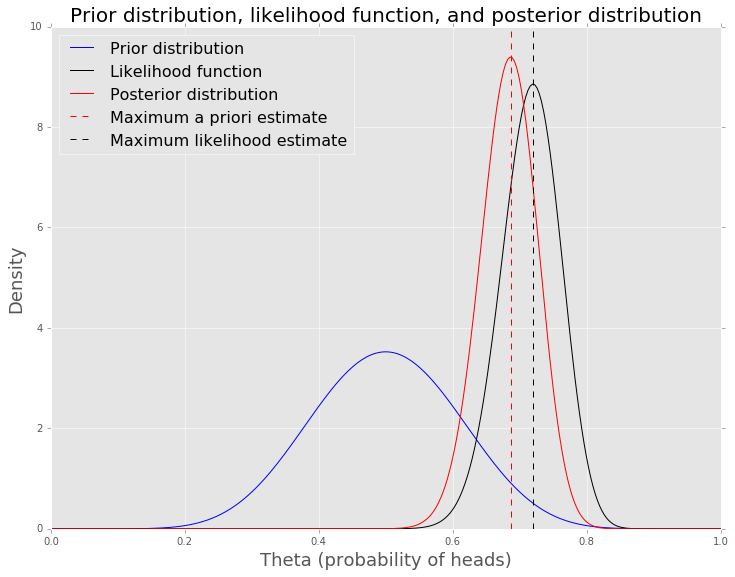

In [3]:
#load modules 
import numpy as np
import scipy.stats as st
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#coin toss initialization
n = 100 #total number of coin tosses
h = 72 #number of tosses that come up heads
p = float(h)/n #proportion of tosses that come up heads

#binomial random variable for our coin toss
rv = st.binom(n, p) #define an instance of a binomial distribution with our coin toss variables
mu = rv.mean() #mean of the distribution

#defining our prior beliefs on the bias of the coin
#(since exactly half the hallucinated tosses are heads, we believe that the coin is unbiased)
a = 10 #10 "hallucinated" tosses came up heads (also called "pseudocounts")
b = 10 #10 "hallucinated" tosses came up tails (also called "pseudocounts")
prior = st.beta(a, b) #construct prior distribution using our prior beliefs about the coin

#defining the posterior distribution, which is also a beta because the beta is the conjugate prior for the binomial
#see https://courses.engr.illinois.edu/cs598jhm/sp2010/Slides/Lecture02HO.pdf for more information
post = st.beta(h+a, n-h+b) #posterior beta distribution has parameters equal to the sum of real and "hallucinated" flips 

#plotting the results
thetas = np.linspace(0, 1, 300) #chop the parameter space into 300 values for plotting
plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior distribution', c='blue') #plot prior density over theta domain
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood function', c='black') #plot likelihood density over theta domain
plt.plot(thetas, post.pdf(thetas), label='Posterior distribution', c='red') #plot posterior density over theta domain
plt.axvline((h+a-1)/float(n+a+b-2), c='red', linestyle='dashed', alpha=1, label='Maximum a priori estimate')
plt.axvline(mu/float(n), c='black', linestyle='dashed', alpha=1, label='Maximum likelihood estimate')
plt.xlim([0, 1])
plt.xlabel('Theta (probability of heads)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Prior distribution, likelihood function, and posterior distribution', fontsize=20)
plt.legend(loc='best', fontsize=16);


The maximum likelihood estimate (MLE) of the parameters gives the most likely parameter values based solely on the data (it's the mode of the likelihood function). The maximum a posteriori (MAP) estimate does the same thing, except it also incorporates our prior beliefs via the prior distribution. In effect, it "regularizes" the result, which can help protect against overfitting to the data. (Note how the posterior distribution is a blend of the likelihood and the prior in the graph above.)

Next, we implement the MH algorithm to try to recover the posterior distribution.

Efficiency:  0.1752
Number of samples (10k):  10000


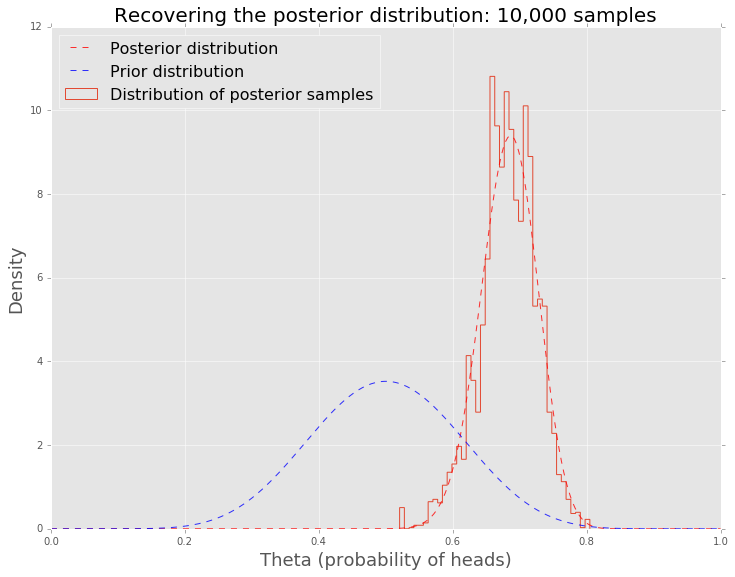

In [4]:
#helper function to compute the probability density for any value of theta
#the "if" clause is needed to restrict us to the allowed domain since 
#...the draws from the gaussian distribution are completely at random
def target(lik, prior, n, h, theta):
    """lik: likelihood; prior: prior distribution;
       n: number of tosses; h: number of heads: theta: current value of theta"""
    if theta < 0 or theta > 1: #if we're outside the allowed domain
        return 0 #return 0
    else: #if we're inside the allowed domain
        return lik(n, theta).pmf(h)*prior.pdf(theta) #return product of likelihood and prior evaluated at theta

#define the main function that generates a desired number of MCMC samples
#the "tracking" argument can be used to track efficiency (or not) as desired
def MH_algorithm(niters, n, h, lik, prior, sigma, tracking=True):
    """niters: number of iterations; n: number of tosses; h: number of heads; 
       lik: likelihood; prior: prior distribution ; sigma: std.dev. of gaussian;
       tracking: whether to track how many proposed updates are accepted"""
    if tracking==False: #we only return the samples, we can't calculate efficiency
        theta = np.random.uniform() #initialize theta randomly
        samples = np.zeros(niters+1) #object to hold the resulting set of theta values
        samples[0] = theta
        for i in range(niters):
            theta_p = theta + st.norm(0, sigma).rvs() #determine proposed update
            rho = min(1, target(lik, prior, n, h, theta_p)/float(target(lik, prior, n, h, theta))) #determine rho
            u = np.random.uniform() #random draw from uniform for comparing to rho
            if u < rho: #note that we will always accept if rho ≥ 1; chance is only involved if rho < 1
                theta = theta_p
            samples[i+1] = theta
        return samples
    else: #here we return samples and can calculate efficiency
        naccept = 0 #initialize tracker for the number of accepted updates
        theta = np.random.uniform() #initialize theta randomly
        samples = np.zeros(niters+1) #object to hold the resulting set of theta values
        samples[0] = theta
        for i in range(niters):
            theta_p = theta + st.norm(0, sigma).rvs() #determine proposed update
            rho = min(1, target(lik, prior, n, h, theta_p)/float(target(lik, prior, n, h, theta))) #determine rho
            u = np.random.uniform() #random draw from uniform for comparing to rho
            if u < rho: #note that we will always accept proposal if rho ≥ 1; chance is only involved if rho < 1
                naccept += 1
                theta = theta_p
            samples[i+1] = theta
        return samples, naccept #return our final set of samples and the number of times we accepted an update

#initializing parameters
lik = st.binom #likelihood is binomial for coin flipping
sigma = 0.3 #tuning parameter for the proposal draws

#base case: run it for 10,000 iterations
niters_10k = 10000
samples_10k, naccept_10k = MH_algorithm(niters_10k, n, h, lik, prior, sigma, tracking=True)
burn_in_10k = len(samples_10k)//2 #ignore the first half of the returned samples as the "burn-in" period
print "Efficiency: ", float(naccept_10k)/niters_10k #compute fraction of iterations where a new value was accepted
print "Number of samples (10k): ", len(samples_10k)-1 #confirm correct length of result

#plot results for 10,000 iterations
thetas = np.linspace(0, 1, 300) #chop theta space into 300 points for plotting
plt.figure(figsize=(12, 9))
plt.hist(samples_10k[burn_in_10k:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='dashed', alpha=0.8, label='Posterior distribution')
plt.plot(thetas, prior.pdf(thetas), c='blue', linestyle='dashed', alpha=0.8, label='Prior distribution')
plt.xlim([0,1]);
plt.xlabel('Theta (probability of heads)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Recovering the posterior distribution: 10,000 samples', fontsize=20)
plt.legend(loc='best', fontsize=16);

The value of using an example where we can know the posterior distribution a priori is that we can explicitly check how well MH approximates it. The plot above shows that the algorithm has done a reasonable job -- compare the red histogram to the red dashed curve retained from the previous plot. However, there is definitely noise present. To demonstrate the influence of the number of samples on the outcome, we repeat the analysis using fewer (1000) and more (30,000) samples.

Efficiency:  0.171
Number of samples (1k):  1000


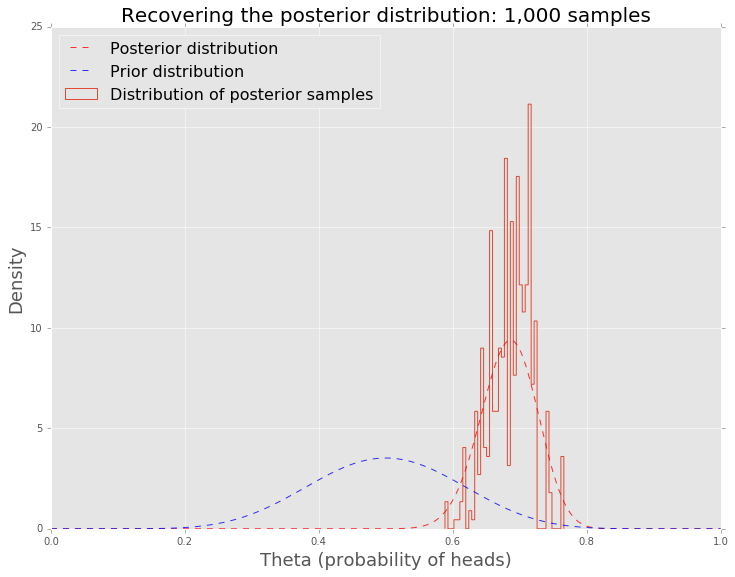

In [5]:
#repeating for 1000 iterations
niters_1k = 1000
samples_1k, naccept_1k = MH_algorithm(niters_1k, n, h, lik, prior, sigma, tracking=True)
burn_in_1k = len(samples_1k)//2 
print "Efficiency: ", float(naccept_1k)/niters_1k 
print "Number of samples (1k): ", len(samples_1k)-1

#plot results for 1000 iterations
plt.figure(figsize=(12, 9))
plt.hist(samples_1k[burn_in_1k:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='dashed', alpha=0.8, label='Posterior distribution')
plt.plot(thetas, prior.pdf(thetas), c='blue', linestyle='dashed', alpha=0.8, label='Prior distribution')
plt.xlim([0,1]);
plt.xlabel('Theta (probability of heads)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Recovering the posterior distribution: 1,000 samples', fontsize=20)
plt.legend(loc='best', fontsize=16);

Efficiency:  0.176933333333
Number of samples:  30000


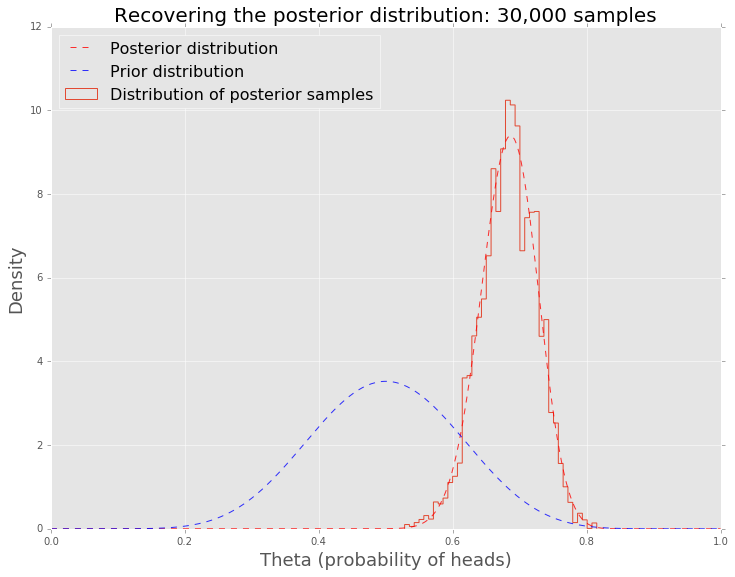

In [6]:
#repeating for 30,000 iterations
niters_30k = 30000
samples_30k, naccept_30k = MH_algorithm(niters_30k, n, h, lik, prior, sigma, tracking=True)
burn_in_30k = len(samples_30k)//2 
print "Efficiency: ", float(naccept_30k)/niters_30k 
print "Number of samples: ", len(samples_30k)-1

#plot results for 30,000 iterations
plt.figure(figsize=(12, 9))
plt.hist(samples_30k[burn_in_30k:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='dashed', alpha=0.8, label='Posterior distribution')
plt.plot(thetas, prior.pdf(thetas), c='blue', linestyle='dashed', alpha=0.8, label='Prior distribution')
plt.xlim([0,1]);
plt.xlabel('Theta (probability of heads)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Recovering the posterior distribution: 30,000 samples', fontsize=20)
plt.legend(loc='best', fontsize=16);

We find that 1000 iterations is extremely noisy, while 30,000 iterations provides a very reasonable approximation to the posterior distribution. As even 30,000 iterations only takes a couple of minutes on a laptop, we conclude it is well worth the additional computation. 

We next consider the effect of the scaling hyperparameter, $\sigma$, the standard deviation of the proposal distribution. With $\sigma$ set to 0.3, the **efficiency**, measured as the number of accepted updates out of the total number of iterations, is about 15-20 percent. (These values are printed just above each of the three plots shown above.) We are interested in understanding how this changes as a function of $\sigma$, and recalculate it below for $\sigma$ = 0.1 and again for $\sigma$ = 0.7. 

In [7]:
#calculate efficiency for sigma = 0.1 and 10,000 iterations
sigma = 0.1
samples_10k, naccept_10k = MH_algorithm(niters_10k, n, h, lik, prior, sigma, tracking=True)
print "Efficiency (sigma = 0.1): ", float(naccept_10k)/niters_10k

#calculate efficiency for sigma = 0.7 and 10,000 iterations
sigma = 0.7
samples_10k, naccept_10k = MH_algorithm(niters_10k, n, h, lik, prior, sigma, tracking=True)
print "Efficiency (sigma = 0.7): ", float(naccept_10k)/niters_10k

sigma = 0.3 #reset to initial

Efficiency (sigma = 0.1):  0.4535
Efficiency (sigma = 0.7):  0.0758


We see that with $\sigma$ = 0.7 the efficiency is about 7-9 percent, while with $\sigma$ = 0.1 the efficiency is about 44-46 percent. This inverse relationship is expected: giving the proposal distribution a larger standard deviation means it is more likely to propose new values for $\theta$ that are significantly less likely under the target distribution than the current value. When this happens, we only accept the update if $\rho$ is greater than a random value drawn from the uniform distribution, so the less probable the new value is, the less likely it will be accepted. Conversely, if $\sigma$ is too low, it will take a very long time to cover the parameter space because each $\Delta\theta$ will be very small. The optimal value of $\sigma$ balances efficiency with an ability to explore the full parameter space in a reasonable number of iterations of the algorithm. 

Finally, we demonstrate that convergence to the stationary distribution occurs regardless of the starting value of $\theta$. 

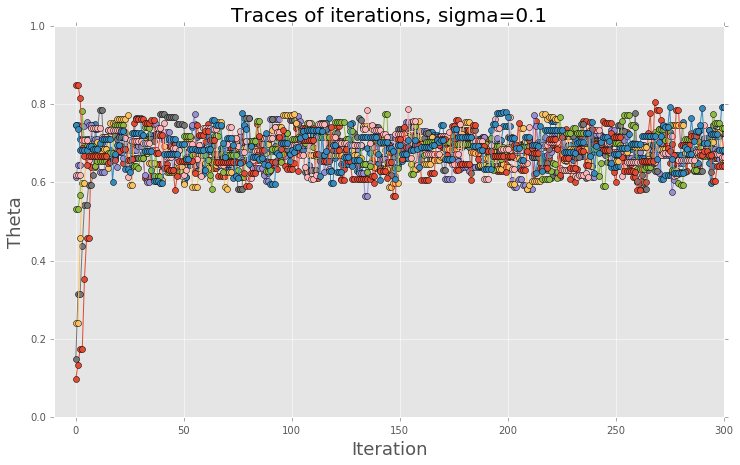

In [8]:
#call the function nine times, for different starting values of theta (0.1, 0.2, ..., 0.9)
#now we set tracking=False to only get back the samples
niters=300
samples_multi_sig1 = [MH_algorithm(niters, n, h, lik, prior, sigma=0.1, tracking=False) for theta in np.arange(0.1, 1, 0.1)] 

#plot result for sigma = 0.1
plt.figure(figsize=(12, 7))
for samples in samples_multi_sig1:
    plt.plot(samples, '-o')
plt.xlim([-10, niters])
plt.ylim([0, 1]);
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Theta', fontsize=18)
plt.title('Traces of iterations, sigma=0.1', fontsize=20);

In the above chunk we've run the MH algorithm nine times, using a range of starting values of $\theta$. Each sequence is plotted in a unique color. This plot demonstrates that convergence to the stationary distribution occurs regardless of starting value. 

One other interesting point is that it's quite easy to see the effect of having a large value of $\sigma$ here. In the plot above we've used a conservative value of $\sigma$, 0.1. This means that most proposed updates are not far from the current value, resulting in high efficiency. For comparison, we rerun this analysis with $\sigma$ = 0.7.

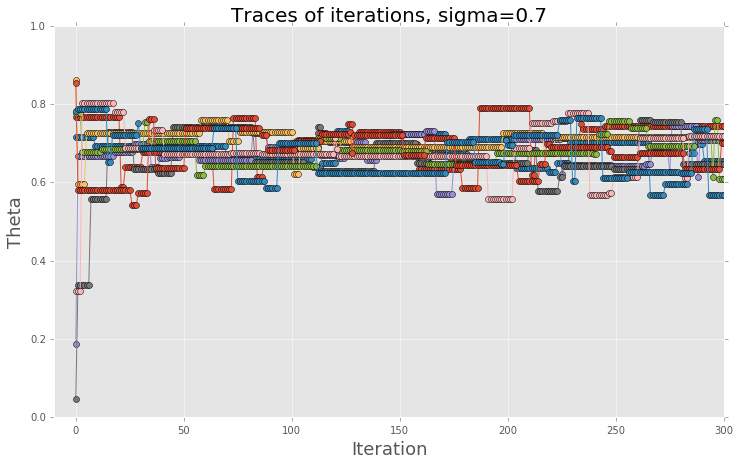

In [9]:
#repeating for sigma = 0.7
samples_multi_sig7 = [MH_algorithm(niters, n, h, lik, prior, sigma=0.7, tracking=False) for theta in np.arange(0.1, 1, 0.1)] 

#plot result for sigma = 0.7
plt.figure(figsize=(12, 7))
for samples in samples_multi_sig7:
    plt.plot(samples, '-o')
plt.xlim([-10, niters])
plt.ylim([0, 1]);
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Theta', fontsize=18)
plt.title('Traces of iterations, sigma=0.7', fontsize=20);

It's clear that this value of $\sigma$ is too large to result in a reasonable probability of accepting updates, as it yields long runs of the same value, as can be seen in the plot above.

### 5. Conclusions
This tutorial has sought to provide an introduction to Markov chain Monte Carlo (MCMC) approximation, with a focus on the Metropolis-Hastings algorithm. There are several other MCMC algorithms in use today not covered in this tutorial. However, the hope is that this document provides enough of a background on MCMC that the reader can more readily learn those methods as needed.

### 6. Additional resources:

* "Metropolis-Hastings algorithm": https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm
* "MCMC sampling for dummies": http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
* "Introduction to Bayesian Statistics, Part 2: MCMC and the Metropolis Hastings algorithm": https://www.youtube.com/watch?v=OTO1DygELpY
* "Markov Chain Monte Carlo": https://people.duke.edu/~ccc14/sta-663/MCMC.html
* "Conjugate priors": https://courses.engr.illinois.edu/cs598jhm/sp2010/Slides/Lecture02HO.pdf


